In [1]:
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models

In [2]:
MODEL_PATH = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plant_disease_classification/plant_disease_model.pth"
CLASS_INDICES_PATH = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plant_disease_classification/class_indices.json"

train_dir = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced"
test_dir = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/val"

train_dir, test_dir

('/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced',
 '/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/val')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size=(28, 28)),
    ]
)

In [4]:
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

test_data = datasets.ImageFolder(root=test_dir, transform=transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 18386
     Root location: /Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 10861
     Root location: /Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
            ))

In [5]:
class_names = train_data.classes
num_classes = len(class_names)
class_dict = train_data.class_to_idx
class_dict, num_classes

({'Apple___Apple_scab': 0,
  'Apple___Black_rot': 1,
  'Apple___Cedar_apple_rust': 2,
  'Apple___healthy': 3,
  'Blueberry___healthy': 4,
  'Cherry_(including_sour)___Powdery_mildew': 5,
  'Cherry_(including_sour)___healthy': 6,
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
  'Corn_(maize)___Common_rust_': 8,
  'Corn_(maize)___Northern_Leaf_Blight': 9,
  'Corn_(maize)___healthy': 10,
  'Grape___Black_rot': 11,
  'Grape___Esca_(Black_Measles)': 12,
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
  'Grape___healthy': 14,
  'Orange___Haunglongbing_(Citrus_greening)': 15,
  'Peach___Bacterial_spot': 16,
  'Peach___healthy': 17,
  'Pepper,_bell___Bacterial_spot': 18,
  'Pepper,_bell___healthy': 19,
  'Potato___Early_blight': 20,
  'Potato___Late_blight': 21,
  'Potato___healthy': 22,
  'Raspberry___healthy': 23,
  'Soybean___healthy': 24,
  'Squash___Powdery_mildew': 25,
  'Strawberry___Leaf_scorch': 26,
  'Strawberry___healthy': 27,
  'Tomato___Bacterial_spot': 28,
  'Toma

In [6]:
import json

idx_to_class = {v: k for k, v in class_dict.items()}

with open(CLASS_INDICES_PATH, "w") as f:
    json.dump(idx_to_class, f)

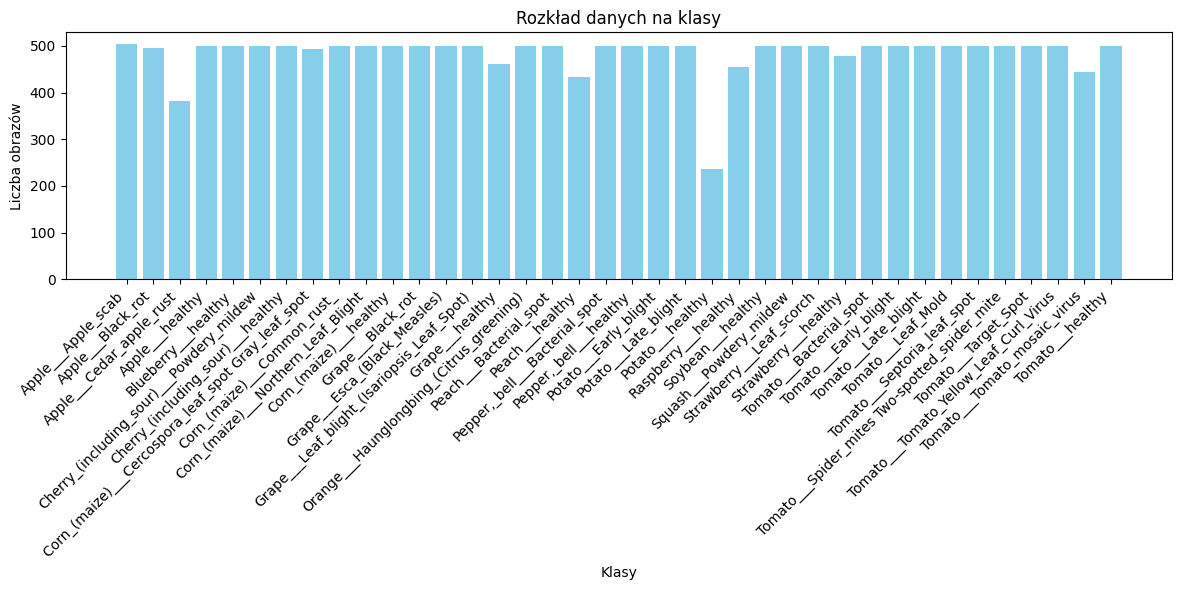

{'Apple___Apple_scab': 504,
 'Apple___Black_rot': 496,
 'Apple___Cedar_apple_rust': 382,
 'Apple___healthy': 500,
 'Blueberry___healthy': 500,
 'Cherry_(including_sour)___Powdery_mildew': 500,
 'Cherry_(including_sour)___healthy': 500,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 494,
 'Corn_(maize)___Common_rust_': 500,
 'Corn_(maize)___Northern_Leaf_Blight': 500,
 'Corn_(maize)___healthy': 500,
 'Grape___Black_rot': 500,
 'Grape___Esca_(Black_Measles)': 500,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 500,
 'Grape___healthy': 462,
 'Orange___Haunglongbing_(Citrus_greening)': 500,
 'Peach___Bacterial_spot': 500,
 'Peach___healthy': 434,
 'Pepper,_bell___Bacterial_spot': 500,
 'Pepper,_bell___healthy': 500,
 'Potato___Early_blight': 500,
 'Potato___Late_blight': 500,
 'Potato___healthy': 237,
 'Raspberry___healthy': 454,
 'Soybean___healthy': 500,
 'Squash___Powdery_mildew': 500,
 'Strawberry___Leaf_scorch': 500,
 'Strawberry___healthy': 479,
 'Tomato___Bacterial_spot': 50

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Zliczanie liczby wystąpień dla każdej klasy
labels = [label for _, label in train_data]
label_counts = Counter(labels)
mapped_counts = {class_names[i]: count for i, count in label_counts.items()}

# Tworzenie wykresu słupkowego
plt.figure(figsize=(12, 6))  # Zwiększenie szerokości wykresu
plt.bar(mapped_counts.keys(), mapped_counts.values(), color='skyblue')

# Dostosowanie etykiet na osi X
plt.xlabel("Klasy")
plt.ylabel("Liczba obrazów")
plt.title("Rozkład danych na klasy")

# Obrót etykiet na osi X o 45 stopni z mniejszym odstępem
plt.xticks(rotation=45, ha='right', fontsize=10)  # ha='right' wyrównuje tekst do prawej
plt.tight_layout()

# Wyświetlanie wykresu
plt.show()

mapped_counts


In [11]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS
)

train_loader, test_loader, NUM_WORKERS

(<torch.utils.data.dataloader.DataLoader at 0x31b9c8c80>,
 2)

In [12]:
model = models.regnet_y_400mf(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
num_epoch = 5
train_losses = []

for epoch in range(num_epoch):
    model.train()
    print(f"Epoch {epoch + 1} / {num_epoch}")
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f"Loss: {running_loss / len(train_loader):.4f}")
train_losses

Epoch 1 / 5


Training 1:  33%|███▎      | 446/1358 [02:46<05:40,  2.68it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
model = models.regnet_y_400mf(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Calculating accuracy"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")

Calculating accuracy: 100%|██████████| 340/340 [01:41<00:00,  3.33it/s]

Accuracy of the network on the test images: 93.14%


In [ ]:
new_transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image


image_paths = ["Apple___Apple_scab.JPG", "Apple___Black_rot.JPG"]
images = [load_image(path) for path in image_paths]

model.eval()
with torch.no_grad():
    for image in images:
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Predicted class: {class_names[predicted.item()]}")

Predicted class: Blueberry___healthy
Predicted class: Apple___Black_rot
